In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from multiprocessing import Pool
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_events import get_match_events
import gandula
from gandula.export.dataframe import pff_frames_to_dataframe
import pandas as pd

In [5]:
RAW_DATA_PATH = '../data/raw/PL-22-23'
INTERMEDIATE_DATA_PATH = '../data/intermediate/PL-22-23'
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"

# 1. Get Data

In [6]:
metadata_df, players_df = pff_frames_to_dataframe(
        gandula.get_frames(
            RAW_DATA_PATH,
            4625,
        )
    )

Loading frames from match 4625: 0 frames [00:00, ? frames/s]

Validating frames:   0%|          | 0/176875 [00:00<?, ? frames/s]

In [7]:
len(metadata_df), len(players_df)/22

(176875, 123743.0)

In [9]:
metadata_df['seconds'] = metadata_df['elapsed_seconds']*metadata_df['period']
metadata_df['interval_id'] =  (metadata_df['seconds']//120 )+ 1
metadata_df['interval_id'] = metadata_df['interval_id'].astype(int)
metadata_df

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,...,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli,seconds,interval_id
0,4625,5259,1,0.000475,0.0,6911618.0,PFF_Frame_GameEventType.FIRST_HALF_KICKOFF,SetPieceType.KICK_OFF,7001.0,221.0,...,5259.0,6801909.0,Frame_PossessionEventType.PASS,5259.0,5259.0,1.0,4.1.0,175475.475,0.000475,1
1,4625,5260,1,0.033842,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175508.842,0.033842,1
2,4625,5261,1,0.067209,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175542.209,0.067209,1
3,4625,5262,1,0.100576,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175575.576,0.100576,1
4,4625,5263,1,0.133942,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175608.942,0.133942,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176870,4625,184556,2,3015.748691,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.1.0,6158024.691,6031.497382,51
176871,4625,184557,2,3015.782058,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.1.0,6158058.058,6031.564116,51
176872,4625,184558,2,3015.815425,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.1.0,6158091.425,6031.630850,51
176873,4625,184559,2,3015.848791,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.1.0,6158124.791,6031.697582,51


In [10]:
events_df = get_match_events(4625)

events_df['event_id'] = events_df['event_id'].astype(float)
events_df['possession_id'] = events_df['possession_id'].astype(float)

events_df

,match_id,team_id,event_id,possession_id,possession_type,player_id,receiver_id,outcome,carry_type
0,4625,221,6911618.0,6801909.0,PASS,7001,230,C,None
1,4625,221,6911620.0,6801911.0,PASS,230,1374,C,None
2,4625,221,6911624.0,6801915.0,PASS,1374,243,C,None
3,4625,221,6911636.0,6801926.0,PASS,243,4927,C,None
4,4625,221,6911648.0,6801937.0,PASS,4927,None,D,None
...,...,...,...,...,...,...,...,...,...
851,4625,16,6919218.0,6809552.0,PASS,9992,None,S,None
852,4625,16,6919242.0,6809573.0,PASS,3972,6656,C,None
853,4625,221,6919266.0,6809597.0,PASS,8328,None,S,None
854,4625,16,6931483.0,6822046.0,PASS,394,6656,C,None


# 2. Preprocess Data

In [33]:
metadata_events_df = metadata_df[((metadata_df['frame_id']==metadata_df['possession_start_frame'])) & (metadata_df['event_setpiece_type'].isnull())]
metadata_events_df

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,...,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli,seconds,interval_id
100,4625,5359,1,3.337145,0.0,6911620.0,PFF_Frame_GameEventType.ON_THE_BALL,None,230.0,221.0,...,5359.0,6801911.0,Frame_PossessionEventType.PASS,5359.0,5359.0,1.0,4.1.0,178812.145,3.337145,1
202,4625,5461,1,6.740549,0.0,6911624.0,PFF_Frame_GameEventType.ON_THE_BALL,None,1374.0,221.0,...,5461.0,6801915.0,Frame_PossessionEventType.PASS,5461.0,5461.0,1.0,4.1.0,182215.549,6.740549,1
242,4625,5501,1,8.075217,0.0,6911636.0,PFF_Frame_GameEventType.ON_THE_BALL,None,243.0,221.0,...,5501.0,6801926.0,Frame_PossessionEventType.PASS,5501.0,5501.0,1.0,4.1.0,183550.217,8.075217,1
311,4625,5570,1,10.377519,0.0,6911648.0,PFF_Frame_GameEventType.ON_THE_BALL,None,4927.0,221.0,...,5619.0,6801936.0,Frame_PossessionEventType.CHALLENGE,5570.0,5619.0,1.0,4.1.0,185852.519,10.377519,1
360,4625,5619,1,12.012487,0.0,6911648.0,PFF_Frame_GameEventType.ON_THE_BALL,None,4927.0,221.0,...,5619.0,6801937.0,Frame_PossessionEventType.PASS,5619.0,5619.0,1.0,4.1.0,187487.487,12.012487,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172913,4625,180599,2,2883.716659,1.0,6919211.0,PFF_Frame_GameEventType.ON_THE_BALL,None,1910.0,16.0,...,180599.0,6809545.0,Frame_PossessionEventType.PASS,180599.0,180599.0,394.0,4.1.0,6025992.659,5767.433318,49
172968,4625,180654,2,2885.551828,1.0,6919218.0,PFF_Frame_GameEventType.ON_THE_BALL,None,9992.0,16.0,...,180654.0,6809552.0,Frame_PossessionEventType.PASS,180654.0,180654.0,394.0,4.1.0,6027827.828,5771.103656,49
175133,4625,182819,2,2957.790733,1.0,6919262.0,PFF_Frame_GameEventType.ON_THE_BALL,None,6656.0,16.0,...,182819.0,6809592.0,Frame_PossessionEventType.CHALLENGE,182819.0,182819.0,395.0,4.1.0,6100066.733,5915.581466,50
175161,4625,182847,2,2958.725001,0.0,6919266.0,PFF_Frame_GameEventType.ON_THE_BALL,None,8328.0,221.0,...,182847.0,6809597.0,Frame_PossessionEventType.PASS,182847.0,182847.0,396.0,4.1.0,6101001.001,5917.450002,50


In [34]:
metadata_events_df.columns

Index(['match_id', 'frame_id', 'period', 'elapsed_seconds',
       'home_has_possession', 'event_id', 'event_type', 'event_setpiece_type',
       'event_player_id', 'event_team_id', 'event_start_frame',
       'event_end_frame', 'possession_id', 'possession_type',
       'possession_start_frame', 'possession_end_frame', 'sequence', 'version',
       'video_time_milli', 'seconds', 'interval_id'],
      dtype='object')

In [12]:
ball_df = players_df[['match_id','frame_id','ball_x','ball_y']].drop_duplicates().reset_index(drop=True)
ball_df

,match_id,frame_id,ball_x,ball_y
0,4625,5259,-1.51,0.62
1,4625,5260,-2.46,1.03
2,4625,5261,-2.46,1.03
3,4625,5262,-3.67,1.47
4,4625,5263,-3.67,1.47
...,...,...,...,...
123115,4625,184554,54.51,5.17
123116,4625,184555,54.26,5.57
123117,4625,184556,54.26,5.57
123118,4625,184557,54.10,5.97


In [13]:
pass_df = events_df[(events_df['possession_type']=='PASS') & (events_df['outcome']=='C')][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
pass_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
0,4625,7001,230,6911618.0,6801909.0,221
1,4625,230,1374,6911620.0,6801911.0,221
2,4625,1374,243,6911624.0,6801915.0,221
3,4625,243,4927,6911636.0,6801926.0,221
8,4625,1374,8328,6911687.0,6801976.0,221
...,...,...,...,...,...,...
849,4625,1910,1910,6919204.0,6809536.0,16
850,4625,1910,9992,6919211.0,6809545.0,16
852,4625,3972,6656,6919242.0,6809573.0,16
854,4625,394,6656,6931483.0,6822046.0,16


In [14]:
carry_df = events_df[(events_df['possession_type']=='CARRY') & ((events_df['carry_type'].isin(['T','C'])) | ((events_df['carry_type']=='D')&(events_df['outcome'].isin(['K','B']))))][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
carry_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
18,4625,400,400,6911764.0,6802055.0,16
21,4625,403,403,6911780.0,6802072.0,16
31,4625,1958,1958,6911816.0,6802106.0,221
40,4625,4282,4282,6911855.0,6802150.0,16
48,4625,4927,4927,6911887.0,6802179.0,221
54,4625,4282,4282,6911916.0,6802210.0,16
58,4625,1374,1374,6911951.0,6802249.0,221
99,4625,7008,7008,6912312.0,6802617.0,221
109,4625,4282,4282,6912415.0,6802714.0,16
158,4625,8328,8328,6912713.0,6803002.0,221


In [15]:
network_df = pd.concat([pass_df,carry_df]).reset_index(drop=True)
network_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
0,4625,7001,230,6911618.0,6801909.0,221
1,4625,230,1374,6911620.0,6801911.0,221
2,4625,1374,243,6911624.0,6801915.0,221
3,4625,243,4927,6911636.0,6801926.0,221
4,4625,1374,8328,6911687.0,6801976.0,221
...,...,...,...,...,...,...
622,4625,400,400,6917490.0,6822244.0,16
623,4625,403,403,6917511.0,6807882.0,16
624,4625,9992,9992,6918560.0,6814344.0,16
625,4625,14116,14116,6918809.0,6809144.0,221


In [16]:
network_frame_df = network_df.merge(metadata_events_df[['match_id','interval_id','frame_id','event_id','possession_id']], on=['match_id','event_id','possession_id'], how='left')
network_frame_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id,interval_id,frame_id
0,4625,7001,230,6911618.0,6801909.0,221,NaN,NaN
1,4625,230,1374,6911620.0,6801911.0,221,1.0,5359.0
2,4625,1374,243,6911624.0,6801915.0,221,1.0,5461.0
3,4625,243,4927,6911636.0,6801926.0,221,1.0,5501.0
4,4625,1374,8328,6911687.0,6801976.0,221,NaN,NaN
...,...,...,...,...,...,...,...,...
623,4625,400,400,6917490.0,6822244.0,16,30.0,147989.0
624,4625,403,403,6917511.0,6807882.0,16,31.0,148280.0
625,4625,9992,9992,6918560.0,6814344.0,16,42.0,169533.0
626,4625,14116,14116,6918809.0,6809144.0,221,45.0,173954.0


In [17]:
network_ball_df = network_frame_df.merge(ball_df, on=['match_id','frame_id'], how='left')
network_ball_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id,interval_id,frame_id,ball_x,ball_y
0,4625,7001,230,6911618.0,6801909.0,221,NaN,NaN,NaN,NaN
1,4625,230,1374,6911620.0,6801911.0,221,1.0,5359.0,-24.96,7.32
2,4625,1374,243,6911624.0,6801915.0,221,1.0,5461.0,-9.10,24.84
3,4625,243,4927,6911636.0,6801926.0,221,1.0,5501.0,5.79,30.88
4,4625,1374,8328,6911687.0,6801976.0,221,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
623,4625,400,400,6917490.0,6822244.0,16,30.0,147989.0,0.29,-5.88
624,4625,403,403,6917511.0,6807882.0,16,31.0,148280.0,19.93,-17.00
625,4625,9992,9992,6918560.0,6814344.0,16,42.0,169533.0,22.15,-5.28
626,4625,14116,14116,6918809.0,6809144.0,221,45.0,173954.0,11.15,-27.99


In [18]:
final_network_df = network_ball_df[network_ball_df['ball_x'].notna()].reset_index(drop=True)
final_network_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id,interval_id,frame_id,ball_x,ball_y
0,4625,230,1374,6911620.0,6801911.0,221,1.0,5359.0,-24.96,7.32
1,4625,1374,243,6911624.0,6801915.0,221,1.0,5461.0,-9.10,24.84
2,4625,243,4927,6911636.0,6801926.0,221,1.0,5501.0,5.79,30.88
3,4625,403,4282,6911716.0,6802007.0,16,1.0,7406.0,-19.88,29.70
4,4625,400,5114,6911726.0,6802018.0,16,1.0,7516.0,-11.68,7.19
...,...,...,...,...,...,...,...,...,...,...
546,4625,400,400,6917490.0,6822244.0,16,30.0,147989.0,0.29,-5.88
547,4625,403,403,6917511.0,6807882.0,16,31.0,148280.0,19.93,-17.00
548,4625,9992,9992,6918560.0,6814344.0,16,42.0,169533.0,22.15,-5.28
549,4625,14116,14116,6918809.0,6809144.0,221,45.0,173954.0,11.15,-27.99


In [29]:
grouped_df = final_network_df.groupby(['match_id','interval_id','team_id','player_id','receiver_id']).size().reset_index(name='count')
grouped_df[grouped_df['interval_id']==1]

,match_id,interval_id,team_id,player_id,receiver_id,count
0,4625,1.0,16,1910,9990,1
1,4625,1.0,16,3972,403,1
2,4625,1.0,16,3972,5114,1
3,4625,1.0,16,400,400,1
4,4625,1.0,16,400,5114,2
5,4625,1.0,16,403,4282,1
6,4625,1.0,16,5114,3972,1
7,4625,1.0,16,9990,3972,1
8,4625,1.0,221,1374,243,1
9,4625,1.0,221,230,1374,1


In [23]:
player_positions_df = final_network_df.groupby(['match_id','team_id','player_id','interval_id']).agg({'ball_x':'mean','ball_y':'mean'}).reset_index()
player_positions_df

,match_id,team_id,player_id,interval_id,ball_x,ball_y
0,4625,16,1910,1.0,-13.670000,16.660
1,4625,16,1910,2.0,-10.826667,22.520
2,4625,16,1910,3.0,5.000000,-13.560
3,4625,16,1910,4.0,-8.950000,14.600
4,4625,16,1910,5.0,25.300000,-15.865
...,...,...,...,...,...,...
351,4625,221,8328,21.0,6.660000,7.310
352,4625,221,8328,23.0,6.900000,-19.550
353,4625,221,8328,27.0,18.190000,26.900
354,4625,221,8328,37.0,23.440000,-2.900


# 3. Explore Data

In [22]:
size = final_network_df.groupby('interval_id').size()
size.describe()

count    45.000000
mean     12.244444
std       7.717028
min       1.000000
25%       7.000000
50%      11.000000
75%      17.000000
max      29.000000
dtype: float64

# 4. Graphs

In [24]:
def create_team_graphs(passes_df, positions_df, interval_id):
    """
    Cria um grafo dirigido (NetworkX) para cada team_id encontrado em 'passes_df'.
    
    Parâmetros:
    ----------
    passes_df: DataFrame com colunas [match_id, team_id, player_id, receiver_id, count].
               Cada linha representa a contagem de passes de 'player_id' -> 'receiver_id'.
    positions_df: DataFrame com colunas [match_id, team_id, player_id, ball_x, ball_y].
                  Cada linha dá a posição média (x,y) daquele jogador no campo.
    
    Retorno:
    --------
    dict onde a chave é o team_id e o valor é um nx.DiGraph.
    Cada grafo tem:
      - Nós = player_id (com atributo 'pos' e 'features' = (ball_x, ball_y))
      - Arestas dirigidas de player_id -> receiver_id (com 'weight' = count).
    """
    
    passes_df = passes_df[passes_df['interval_id'] == interval_id].reset_index(drop=True)
    positions_df = positions_df[positions_df['interval_id'] == interval_id].reset_index(drop=True)


    # Identifica todos os times disponíveis no DF de passes
    teams = passes_df['team_id'].unique()
    graphs_dict = {}

    for team in teams:
        # Filtra o DF de passes para esse time
        sub_passes_df = passes_df[passes_df['team_id'] == team]
        # Filtra o DF de posições para esse time
        sub_positions_df = positions_df[positions_df['team_id'] == team]

        # Cria um grafo dirigido para este time
        G = nx.DiGraph(name=f"team_{team}")

        # Adiciona cada player_id como nó, com atributo de posição (ball_x, ball_y)
        # Vamos supor que cada combinação (match_id, team_id, player_id) seja única
        for row in sub_positions_df.itertuples():
            player_id = row.player_id
            x_coord = row.ball_x
            y_coord = row.ball_y

            # Adicionamos o nó, salvando a posição em 'pos' e 'features'
            G.add_node(
                player_id,
                pos=(x_coord, y_coord),
                features=(x_coord, y_coord)
            )

        # Adiciona as arestas a partir de sub_passes_df
        # Direção: player_id -> receiver_id, peso = count
        for row in sub_passes_df.itertuples():
            source = row.player_id
            target = row.receiver_id
            count = row.count

            # Cria a aresta com peso
            # Se preferir, pode somar caso já exista, mas aqui sobrescrevemos
            G.add_edge(source, target, weight=count)

        # Guarda o grafo no dicionário
        graphs_dict[team] = G
    
    return graphs_dict

In [26]:
graphs = create_team_graphs(grouped_df,player_positions_df,1)
graphs

{'16': <networkx.classes.digraph.DiGraph at 0x225c1932780>,
 '221': <networkx.classes.digraph.DiGraph at 0x225c19328d0>}

In [28]:
pos

{'1910': (-13.67, 16.66),
 '3972': (-15.105, 2.7800000000000002),
 '400': (-16.07, 1.8133333333333337),
 '403': (-19.88, 29.7),
 '5114': (-2.25, 25.35),
 '9990': (-36.27, 7.95)}

NetworkXError: Node '4282' has no position.

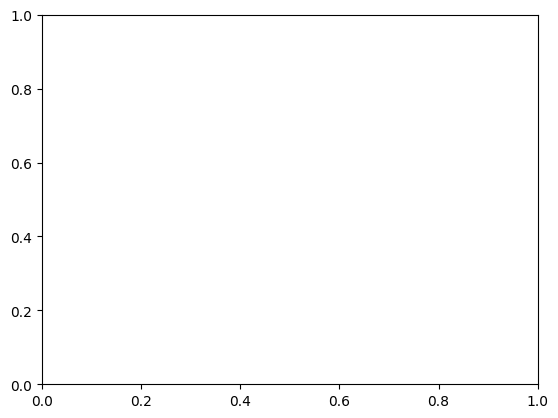

In [27]:
home_graph = graphs['16']
pos = nx.get_node_attributes(home_graph, 'pos')  # pega as posições dos nós
edge_widths = [d['weight'] for (_, _, d) in home_graph.edges(data=True)]  # lista de weights

# Usa draw_networkx, que chama internamente as funções para desenhar nós, arestas e rótulos
nx.draw_networkx(
    home_graph, 
    pos=pos, 
    with_labels=True, 
    node_size=1000, 
    font_size=8, 
    width=edge_widths  # <-- aqui variamos a espessura de cada aresta
)

plt.show()